## Download Data from Kaggle
[Data](https://www.kaggle.com/datasets/nodoubttome/skin-cancer9-classesisic)   EN. This set consists of 2357 images of malignant and benign oncological diseases, which were formed from The International Skin Imaging Collaboration (ISIC). All images were sorted according to the classification taken with ISIC, and all subsets were divided into the same number of images, with the exception of melanomas and moles, whose images are slightly dominant.

The data set contains the following diseases:
- actinic keratosis
- basal cell carcinoma
- dermatofibroma
- melanoma
- nevus
- pigmented benign keratosis
- seborrheic keratosis
- squamous cell carcinoma
- vascular lesion

In [1]:
!pip install -U -q kaggle

In [2]:
from google.colab import files
files.upload()
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d nodoubttome/skin-cancer9-classesisic

 98% 771M/786M [00:05<00:00, 207MB/s]
100% 786M/786M [00:05<00:00, 144MB/s]


In [ ]:
!unzip /content/skin-cancer9-classesisic.zip

## Import Library

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from PIL import Image

import keras
from keras.utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.layers import BatchNormalization

from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split

In [6]:
TRAIN_DIR = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train"
TEST_DIR = "/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test"

In [7]:
import os
import shutil

# Daftar label yang ingin Anda ambil
selected_labels = ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma']

# Direktori tempat Anda ingin menyimpan data yang dipilih
selected_train_dir = "train"
selected_test_dir = "test"

# Fungsi untuk menyalin gambar berdasarkan label
def copy_images_for_labels(label_list, source_dir, dest_dir):
    for label in label_list:
        label_source_dir = os.path.join(source_dir, label)
        label_dest_dir = os.path.join(dest_dir, label)

        # Membuat direktori jika belum ada
        os.makedirs(label_dest_dir, exist_ok=True)

        # Menyalin file dari direktori sumber ke direktori tujuan
        for file_name in os.listdir(label_source_dir):
            source_path = os.path.join(label_source_dir, file_name)
            dest_path = os.path.join(label_dest_dir, file_name)
            shutil.copy2(source_path, dest_path)

# Menyalin gambar untuk data pelatihan
copy_images_for_labels(selected_labels, TRAIN_DIR, selected_train_dir)

# Menyalin gambar untuk data pengujian
copy_images_for_labels(selected_labels, TEST_DIR, selected_test_dir)


In [8]:
train_df = pd.DataFrame(columns=['image_path', 'label'])
test_df = pd.DataFrame(columns=['image_path', 'label'])

for label, directory in enumerate(os.listdir(selected_train_dir)):
    for filename in os.listdir(os.path.join(selected_train_dir, directory)):
        image_path = os.path.join(selected_train_dir, directory, filename)
        train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

for label, directory in enumerate(os.listdir(selected_test_dir)):
    for filename in os.listdir(os.path.join(selected_test_dir, directory)):
        image_path = os.path.join(selected_test_dir, directory, filename)
        test_df = test_df.append({'image_path': image_path, 'label': label}, ignore_index=True)

# Combine train_df and test_df into one dataframe
df = pd.concat([train_df, test_df], ignore_index=True)
del test_df,train_df

<ipython-input-8-568eaafc2767>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-568eaafc2767>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-568eaafc2767>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 'label': label}, ignore_index=True)
<ipython-input-8-568eaafc2767>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = train_df.append({'image_path': image_path, 

In [9]:
df.head()

,image_path,label
0,train/basal cell carcinoma/ISIC_0026337.jpg,0
1,train/basal cell carcinoma/ISIC_0031236.jpg,0
2,train/basal cell carcinoma/ISIC_0027473.jpg,0
3,train/basal cell carcinoma/ISIC_0028542.jpg,0
4,train/basal cell carcinoma/ISIC_0029857.jpg,0


In [10]:
labels = os.listdir(selected_train_dir)

# Create label map dict
LABEL_MAP = {i: label for i, label in enumerate(labels)}
NUM_CLASS = len(LABEL_MAP)
LABEL_MAP

{0: 'basal cell carcinoma',
 1: 'dermatofibroma',
 2: 'melanoma',
 3: 'actinic keratosis'}

## Exploratory Data Analysis:

Label distribution: A pie chart is plotted to visualize the distribution of labels in the df dataframe.

Class counts: The number of images in each class is counted and printed.


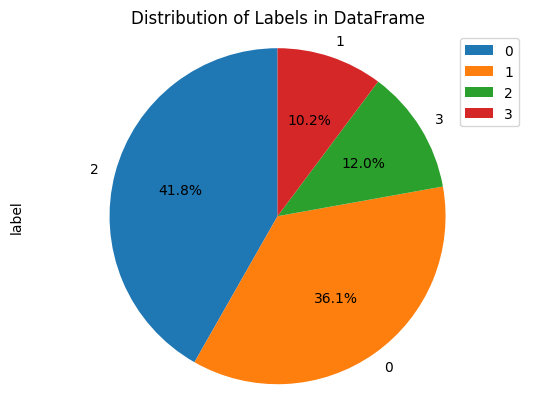

In [11]:
# Plot pie chart of train_df
df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.axis('equal')
plt.title('Distribution of Labels in DataFrame')
plt.legend(df['label'].unique())
plt.show()

In [12]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in LABEL_MAP.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               basal cell carcinoma           392       
1               dermatofibroma                 111       
2               melanoma                       454       
3               actinic keratosis              130       
------------------------------------------------------------
Total                                         1087      


In [13]:
max_images_per_class = 2500

# Group by label column and take first max_images_per_class rows for each group
df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)

<ipython-input-13-bc8b811b80a6>:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df = df.groupby("label").apply(lambda x: x.head(max_images_per_class)).reset_index(drop=True)


In [15]:
import tensorflow as tf

# Allow gpu usage
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
try:
    tf.config.experimental.set_memory_growth = True
except Exception as ex:
    print(e)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [16]:
import multiprocessing

# Get the number of CPU cores available
max_workers = multiprocessing.cpu_count()
max_workers

2

**Parallelization**: The resizing process is parallelized using concurrent.futures.ThreadPoolExecutor to speed up the computation.


In [17]:
import concurrent.futures

# Define a function to resize image arrays
def resize_image_array(image_path):
    return np.asarray(Image.open(image_path).resize((100,75)))

# Use concurrent.futures to parallelize the resizing process
with concurrent.futures.ThreadPoolExecutor(max_workers=max_workers) as executor:
    # Use executor.map to apply the function to each image path in the DataFrame
    image_arrays = list(executor.map(resize_image_array, df['image_path'].tolist()))

# Add the resized image arrays to the DataFrame
df['image'] = image_arrays
del image_arrays

In [18]:
df.head()

,image_path,label,image
0,train/basal cell carcinoma/ISIC_0026337.jpg,0,"[[[176, 165, 180], [176, 165, 178], [177, 165,..."
1,train/basal cell carcinoma/ISIC_0031236.jpg,0,"[[[186, 136, 143], [189, 139, 146], [187, 137,..."
2,train/basal cell carcinoma/ISIC_0027473.jpg,0,"[[[187, 129, 113], [195, 128, 113], [194, 119,..."
3,train/basal cell carcinoma/ISIC_0028542.jpg,0,"[[[173, 155, 165], [178, 158, 169], [179, 157,..."
4,train/basal cell carcinoma/ISIC_0029857.jpg,0,"[[[191, 167, 173], [192, 169, 178], [193, 168,..."


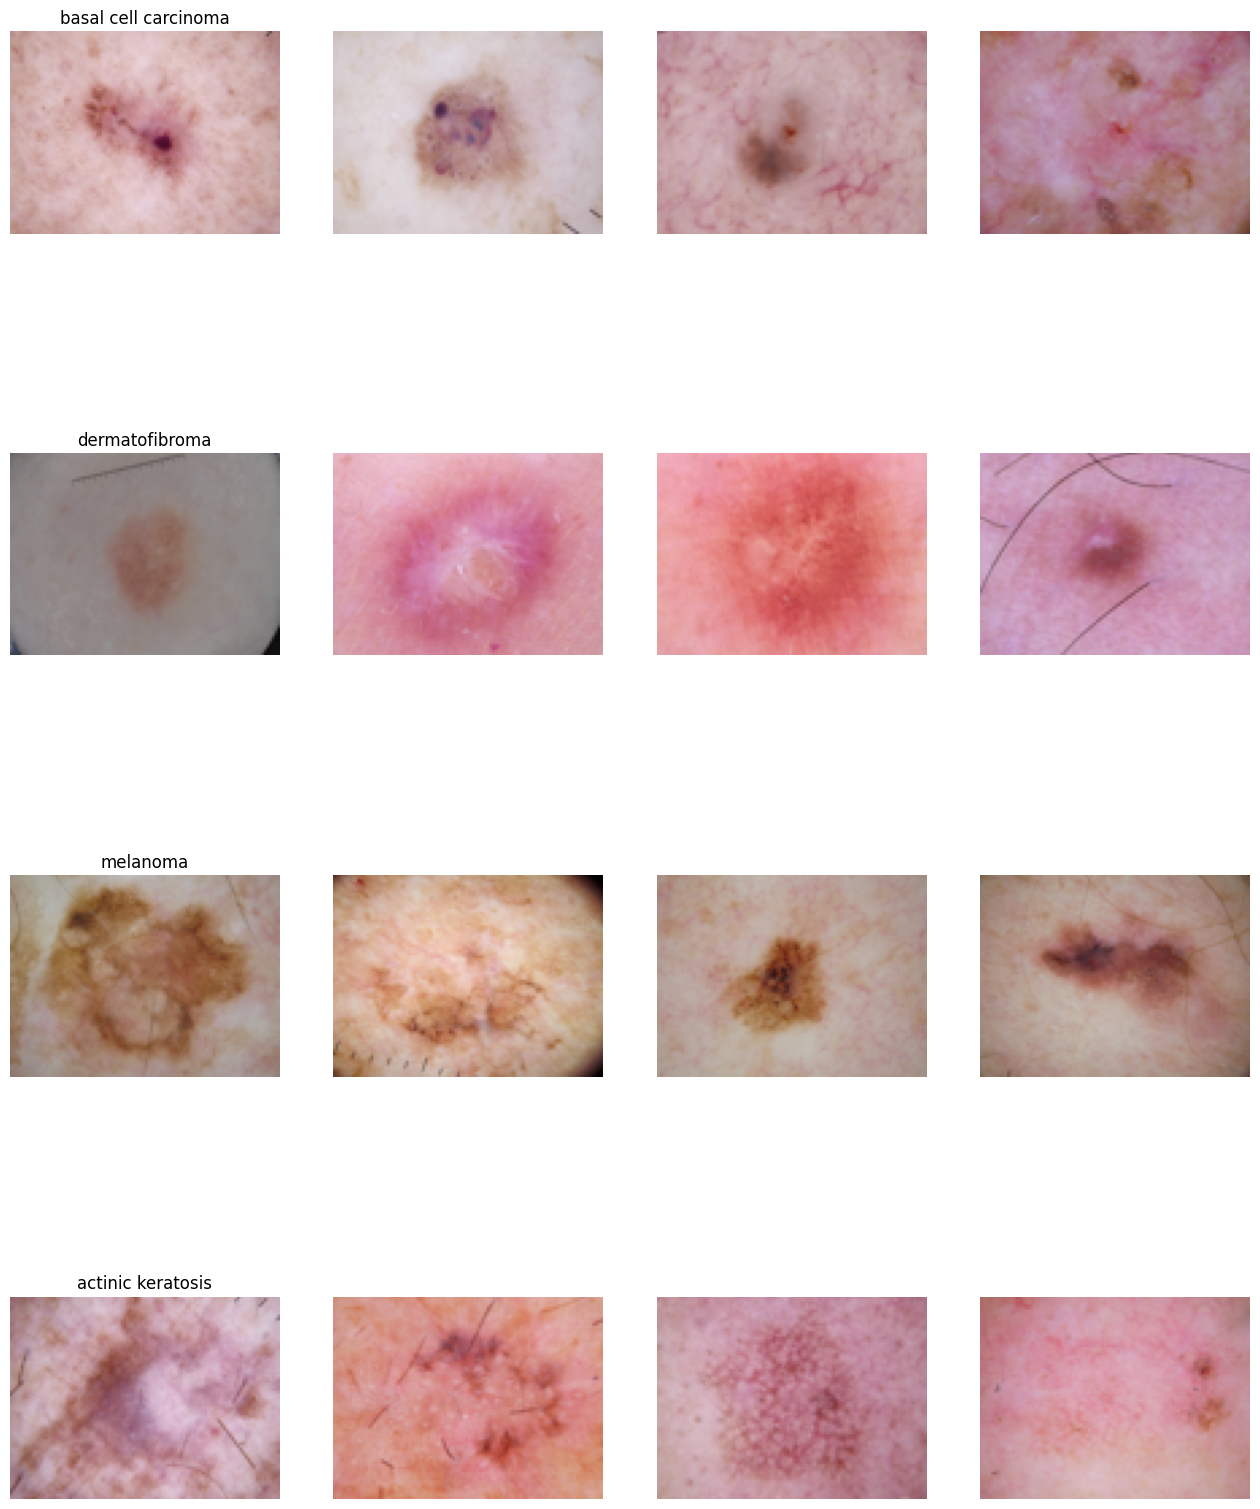

In [19]:
n_samples = 4
fig, m_axs = plt.subplots(NUM_CLASS, n_samples, figsize=(4*n_samples, 3*7))
for n_axs, (class_idx, class_rows) in zip(m_axs, df.sort_values(['label']).groupby('label')):
    class_name = LABEL_MAP[class_idx] # get the class name using label_map
    n_axs[0].set_title(class_name)
    for c_ax, (_, c_row) in zip(n_axs, class_rows.sample(n_samples, random_state=5).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [20]:
df['image'].map(lambda x: x.shape).value_counts()

(75, 100, 3)    1087
Name: image, dtype: int64

**Augmentation**: The code uses ImageDataGenerator from Keras to perform data augmentation, including rotation, shifting, shearing, zooming, and flipping. Augmented images are generated for each class until the desired number of images per class (max_images_per_class) is reached.


In [21]:
# Create an ImageDataGenerator object with the desired transformations
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [22]:
# Create an empty dataframe to store the augmented images
augmented_df = pd.DataFrame(columns=['image_path', 'label', 'image'])

# Loop through each class label and generate additional images if needed
for class_label in df['label'].unique():
    # Get the image arrays for the current class
    image_arrays = df.loc[df['label'] == class_label, 'image'].values
        # Calculate the number of additional images needed for the current class
    num_images_needed = max_images_per_class - len(image_arrays)
     # Generate augmented images for the current class
    if num_images_needed > 0:
        # Select a random subset of the original images
        selected_images = np.random.choice(image_arrays, size=num_images_needed)

          # Apply transformations to the selected images and add them to the augmented dataframe
        for image_array in selected_images:
            # Reshape the image array to a 4D tensor with a batch size of 1
            image_tensor = np.expand_dims(image_array, axis=0)

            # Generate the augmented images
            augmented_images = datagen.flow(image_tensor, batch_size=1)
            # Extract the augmented image arrays and add them to the augmented dataframe
            for i in range(augmented_images.n):
                augmented_image_array = augmented_images.next()[0].astype('uint8')
                augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)



     # Add the original images for the current class to the augmented dataframe
    original_images_df = df.loc[df['label'] == class_label, ['image_path', 'label', 'image']]
    augmented_df = augmented_df.append(original_images_df, ignore_index=True)

# Group the augmented dataframe by the 'label' column and filter out extra images
df = augmented_df.groupby('label').head(max_images_per_class)

del augmented_df

# Use the augmented dataframe for further processing
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

Streaming output truncated to the last 5000 lines.
<ipython-input-22-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-22-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-22-63f691760f75>:25: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  augmented_df = augmented_df.append({'image_path': None, 'label': class_label, 'image': augmented_image_array}, ignore_index=True)
<ipython-input-22-63f691760f75>:25: FutureWarn

In [23]:
# Count the number of images in each class
class_counts = df['label'].value_counts().sort_index()

# Print the number of images in each class
print("Dataset Summary")
print("-" * 60)
print(f"{'Class Label':<15} {'Class Name':<30} {'Count':<10}")
print("-" * 60)
for class_label, class_name in LABEL_MAP.items():
    count = class_counts[class_label]
    print(f"{class_label:<15} {class_name:<30} {count:<10}")
print("-" * 60)
print(f"{'Total':<45} {sum(class_counts):<10}")

Dataset Summary
------------------------------------------------------------
Class Label     Class Name                     Count     
------------------------------------------------------------
0               basal cell carcinoma           2500      
1               dermatofibroma                 2500      
2               melanoma                       2500      
3               actinic keratosis              2500      
------------------------------------------------------------
Total                                         10000     


In [24]:
features = df.drop(columns=['label','image_path'],axis=1)
target = df['label']

In [25]:
features.head()

,image
0,"[[[151, 115, 102], [153, 117, 103], [154, 118,..."
1,"[[[251, 193, 192], [251, 197, 190], [252, 202,..."
2,"[[[212, 175, 174], [211, 175, 174], [211, 175,..."
3,"[[[220, 182, 210], [220, 182, 210], [220, 182,..."
4,"[[[233, 144, 153], [233, 144, 151], [233, 144,..."


In [26]:
target.head()

0    2
1    1
2    0
3    1
4    1
Name: label, dtype: object

## Split Data

In [27]:
x_train, x_test, y_train, y_test = train_test_split(features, target, test_size=0.20,shuffle=True)

In [28]:
x_train = np.asarray(x_train['image'].tolist())
x_test = np.asarray(x_test['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)
x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

# Normalize array
x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std


In [29]:
# Perform one-hot encoding on the labels
y_train = to_categorical(y_train,num_classes = NUM_CLASS)
y_test = to_categorical(y_test,num_classes = NUM_CLASS)

In [30]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.2,shuffle=True)

In [31]:
# Reshape image in 3 dimensions (height = 75px, width = 100px , canal = 3)
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [32]:
y_train = y_train.astype(int)
y_validate = y_validate.astype(int)

In [33]:
# Calculate the number of images in each class for train, validation, and test datasets
train_counts = np.sum(y_train, axis=0)
val_counts = np.sum(y_validate, axis=0)
test_counts = np.sum(y_test, axis=0)

# Print the number of images in each class for train, validation, and test datasets
print("Dataset Summary")
print("-" * 90)
print(f"{'Class Label':<15} {'Class Name':<30} {'Train':<10} {'Validation':<12} {'Test':<10} {'Total':<10}")
print("-" * 90)
for class_label, class_name in LABEL_MAP.items():
    train_num = int(train_counts[class_label])
    val_num = int(val_counts[class_label])
    test_num = int(test_counts[class_label])
    total_num = train_num + val_num + test_num
    print(f"{class_label:<15} {class_name:<30} {train_num:<10} {val_num:<12} {test_num:<10} {total_num:<10}")
print("-" * 90)
print(f"{'Total':<46} {len(y_train):<10} {len(y_validate):<12} {len(y_test):<10} {len(y_train) + len(y_validate) + len(y_test):<10}")




Dataset Summary
------------------------------------------------------------------------------------------
Class Label     Class Name                     Train      Validation   Test       Total     
------------------------------------------------------------------------------------------
0               basal cell carcinoma           1587       392          521        2500      
1               dermatofibroma                 1597       406          497        2500      
2               melanoma                       1653       372          475        2500      
3               actinic keratosis              1563       430          507        2500      
------------------------------------------------------------------------------------------
Total                                          6400       1600         2000       10000     


In [34]:
df.groupby('label').size()

label
0    2500
1    2500
2    2500
3    2500
dtype: int64

In [35]:
input_shape = df['image'][0].shape
input_shape

(75, 100, 3)

## Model
DenseNet201 architecture: The model architecture is defined using the Sequential API from Keras. The DenseNet201 pre-trained model is loaded with weights from the ImageNet dataset as the base model. The top layers of the base model are flattened and followed by a Dropout layer with a dropout rate of 0.5. Two dense layers are added, with ReLU activation in the first dense layer and softmax activation in the output layer.

In [36]:
from tensorflow.keras.applications.resnet import preprocess_input as resnet_prep
from tensorflow.keras.applications import DenseNet201

In [37]:
#  DenseNet201
model = Sequential()
model.add(DenseNet201(include_top=False, weights='imagenet', input_shape=input_shape))
model.add(Flatten())
model.add(Dropout(0.5))  # Add a Dropout layer with a dropout rate of 0.5
model.add(Dense(512, activation='relu'))
model.add(Dense(NUM_CLASS, activation='softmax'))

model.summary()

74836368/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 2, 3, 1920)        18321984  
                                                                 
 flatten (Flatten)           (None, 11520)             0         
                                                                 
 dropout (Dropout)           (None, 11520)             0         
                                                                 
 dense (Dense)               (None, 512)               5898752   
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24222788 (92.40 MB)
Trainable params: 23993732 (91.53 MB)
Non-trainable params: 229056 (894.75 KB)
__________

**Compilation**: The model is compiled with the SGD optimizer, a learning rate of 0.001, and categorical cross-entropy loss.
Learning rate reduction: A learning rate reduction callback is defined using ReduceLROnPlateau to adjust the learning rate during training based on the validation accuracy.

In [38]:
# compile model
from keras.optimizers import SGD
opt = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

## Training

In [40]:
# Fit the model
epochs=10
batch_size=16
history = model.fit(x=x_train,
                    y=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(x_validate,y_validate),
                    callbacks=learning_rate_reduction)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9894

400/400 [==============================] - 52s 130ms/step - loss: 0.0371 - accuracy: 0.9894 - val_loss: 0.0521 - val_accuracy: 0.9775 - lr: 0.0010
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9906

400/400 [==============================] - 50s 125ms/step - loss: 0.0295 - accuracy: 0.9906 - val_loss: 0.0364 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 0.0245 - accuracy: 0.9917

400/400 [==============================] - 50s 126ms/step - loss: 0.0245 - accuracy: 0.9917 - val_loss: 0.0485 - val_accuracy: 0.9831 - lr: 0.0010
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 0.0186 - accuracy: 0.9937

400/400 [==============================] - 53s 132ms/step - loss: 0.0186 - accuracy: 0.9937 - val_loss: 0.0383 - val_accuracy: 0.9900 - lr: 0.0010
Epoch 5/10
400/400 [==============================] - ETA: 0s - loss: 0.0097 - accuracy: 0.9966

400/400 [==============================] - 50s 125ms/step - loss: 0.0097 - accuracy: 0.9966 - val_loss: 0.0630 - val_accuracy: 0.9856 - lr: 0.0010
Epoch 6/10
400/400 [==============================] - ETA: 0s - loss: 0.0300 - accuracy: 0.9909

400/400 [==============================] - 51s 126ms/step - loss: 0.0300 - accuracy: 0.9909 - val_loss: 0.0730 - val_accuracy: 0.9806 - lr: 0.0010
Epoch 7/10
400/400 [==============================] - ETA: 0s - loss: 0.0288 - accuracy: 0.9916

400/400 [==============================] - 50s 126ms/step - loss: 0.0288 - accuracy: 0.9916 - val_loss: 0.1182 - val_accuracy: 0.9600 - lr: 0.0010
Epoch 8/10
400/400 [==============================] - ETA: 0s - loss: 0.0342 - accuracy: 0.9887

400/400 [==============================] - 50s 125ms/step - loss: 0.0342 - accuracy: 0.9887 - val_loss: 0.0550 - val_accuracy: 0.9850 - lr: 0.0010
Epoch 9/10
400/400 [==============================] - ETA: 0s - loss: 0.0135 - accuracy: 0.9952

400/400 [==============================] - 53s 132ms/step - loss: 0.0135 - accuracy: 0.9952 - val_loss: 0.0201 - val_accuracy: 0.9931 - lr: 0.0010
Epoch 10/10
400/400 [==============================] - ETA: 0s - loss: 0.0221 - accuracy: 0.9923

400/400 [==============================] - 50s 126ms/step - loss: 0.0221 - accuracy: 0.9923 - val_loss: 0.0361 - val_accuracy: 0.9875 - lr: 0.0010


## Training and Testing accuracy
 The model is evaluated on the training and testing sets, and the accuracy and loss are printed.
Confusion matrix: The confusion matrix is calculated using confusion_matrix from scikit-learn and visualized using a heatmap with seaborn.
Additional metrics.

In [41]:
loss, accuracy = model.evaluate(x_train, y_train, verbose=1)
print("Train: accuracy = %f  ;  loss = %f" % (accuracy, loss))

200/200 [==============================] - 14s 39ms/step - loss: 8.3059e-04 - accuracy: 0.9998
Train: accuracy = 0.999844  ;  loss = 0.000831


In [42]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
print("Testing: accuracy = %f  ;  loss = %f" % (accuracy, loss))

63/63 [==============================] - 6s 45ms/step - loss: 0.0134 - accuracy: 0.9970
Testing: accuracy = 0.997000  ;  loss = 0.013406


63/63 [==============================] - 6s 40ms/step


<Axes: >

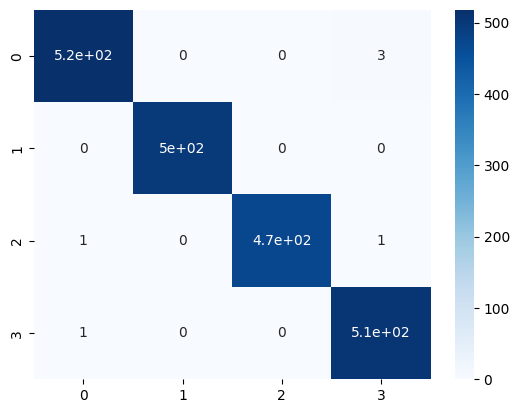

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get the predicted probabilities for the test set
y_pred_prob = model.predict(x_test)

# Find the class with the highest probability for each sample
y_pred = np.argmax(y_pred_prob, axis=1)

# Calculate the confusion matrix
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

# Plot the confusion matrix using Seaborn
sns.heatmap(cm, annot=True, cmap='Blues')

In [44]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score

# Calculate evaluation metrics
accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)
precision = precision_score(np.argmax(y_test, axis=1), y_pred, average='macro')
recall = recall_score(np.argmax(y_test, axis=1), y_pred, average='macro')
f1 = f1_score(np.argmax(y_test, axis=1), y_pred, average='macro')
kappa = cohen_kappa_score(np.argmax(y_test, axis=1), y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Kappa score: {kappa:.4f}")

Accuracy: 0.9970
Precision: 0.9971
Recall: 0.9970
F1-score: 0.9970
Kappa score: 0.9960


In [45]:
# Save model
model_name = "densenet201_cancer.h5"
model.save(model_name)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Prediction

In [46]:
# Load Model
loaded_model = tf.keras.models.load_model(model_name)

In [47]:
from PIL import Image
import numpy as np
import keras

def preprocess_image(image_path):
    image = Image.open(image_path).resize((100, 75))
    image_array = np.array(image, dtype=np.float32) - 162.57063208888889
    image_array /= 41.96703347421026
    image_array = np.expand_dims(image_array, axis=0)
    return image_array

def predict_image(image_path, model):
    # Preprocess the image
    image_array = preprocess_image(image_path)

    # Perform prediction
    prediction = model.predict(image_array)
    predicted_class = np.argmax(prediction)

    return predicted_class


In [59]:
image_path = "/content/test/melanoma/ISIC_0000002.jpg"
image_array = preprocess_image(image_path)

# Perform prediction
prediction = loaded_model.predict(image_array)
predicted_class = np.argmax(prediction)

# Menggunakan softmax untuk mengonversi nilai output menjadi probabilitas
probabilities = tf.nn.softmax(prediction[0])

# Menampilkan hasil prediksi dengan nama kelas dan probabilitasnya
for i, probability in enumerate(probabilities):
    class_name = LABEL_MAP[i]
    print(f"{class_name}: {probability * 100:.2f}%")

print(f"Predicted class: {predicted_class}")

1/1 [==============================] - 0s 66ms/step
basal cell carcinoma: 17.49%
dermatofibroma: 17.49%
melanoma: 47.54%
actinic keratosis: 17.49%
Predicted class: 2


In [49]:
LABEL_MAP

{0: 'basal cell carcinoma',
 1: 'dermatofibroma',
 2: 'melanoma',
 3: 'actinic keratosis'}

In [61]:
import shutil

# Ganti 'path/to/your/model' dengan jalur yang sesuai
model_directory = 'densenet201_cancer.h5'

# Ganti 'model.zip' dengan nama zip yang diinginkan
shutil.make_archive('model', 'zip', model_directory)


'/content/model.zip'